In [9]:
import pandas as pd
import tensorflow as tf
df_data = pd.read_table("./data/SMSSpamCollection", header=None, sep='\t')
df_data.columns = ['label', 'sentence']

In [10]:
from collections import Counter
label, sentences = df_data['label'], df_data['sentence']
Counter(label)

Counter({'ham': 4825, 'spam': 747})

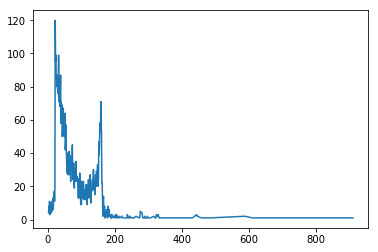

In [11]:
import matplotlib.pyplot as plt
from collections import Counter


length = []
for sentence in sentences:
    length.append(len(sentence))
    
mat = dict(sorted(Counter(length).items(), key=lambda x: x[0]))
x, y = list(mat.keys()),  list(mat.values())

plt.plot(x, y)
plt.show()
plt.close()

In [12]:
def one_hot_encoder(label):
    import numpy as np
    one_hot_label = np.zeros(shape=[len(label), 2])
    one_hot_label[np.arange(0, len(label)), label] = 1
    return one_hot_label

In [13]:
import numpy as np

from tensorflow.contrib import learn
from collections import Counter
from sklearn.model_selection import train_test_split

class Feature(object):
    def __init__(self):
        self.train_df = pd.read_table("./data/SMSSpamCollection", header=None, sep='\t')
        self.train_df.columns = ['label', 'sentence']
        self.sentence = self.train_df['sentence'].values
        self.label = [1 if label == 'ham' else 0 for label in self.train_df['label'].values]
        self.one_hot_label = one_hot_encoder(self.label)

        self.vocab_processor = learn.preprocessing.VocabularyProcessor(200, min_frequency=1)
        self.all_context = np.array(list(self.vocab_processor.fit_transform(self.sentence)))

        print("number of words :", len(self.vocab_processor.vocabulary_))
        self.train_data, self.dev_data, self.train_label, self.dev_label = \
            train_test_split(self.all_context, self.one_hot_label, test_size=0.05)
        # print("shape of train data:", self.train_data.shape)
        # print("shape of dev data:", self.dev_data.shape)
        # print("shape of train label:", self.train_label.shape)
        # print("shape of dev label:", self.dev_label.shape)

feature = Feature()

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
number of words : 5395


In [16]:
import random

def get_batch(epoches, batch_size, data, label):
    # train_x, train_y = pickle.load(open("corpus_train.pkl", "rb"))
    samples = list(zip(data, label))
    random.shuffle(samples)
    for epoch in range(epoches):
        for batch in range(0, len(samples), batch_size):
            if batch + batch_size < len(samples):
                yield samples[batch: (batch + batch_size)]

In [52]:
import datetime

def train_step(model, batch, label):
    feed_dict = {
        model.model.input_sentence: batch,
        model.model.label: label
    }
    _, summary, step, loss, accuracy, = model.sess.run(
        fetches=[model.optimizer,
                 model.merged_summary_train,
                 model.global_step,
                 model.model.loss,
                 model.model.accuracy],
        feed_dict=feed_dict)
    model.summary_writer_train.add_summary(summary, step)
    time_str = datetime.datetime.now().isoformat()
    # print("{}: step {}, loss {}, accuracy {}".format(time_str, step, loss, accuracy))

In [53]:
def dev_step(model, batch, label, return_predict=False):
    feed_dict = {
        model.model.input_sentence: batch,
        model.model.label: label
    }
    summary, step, loss, accuracy, predict = model.sess.run(
        fetches=[model.merged_summary_test,
                 model.global_step,
                 model.model.loss,
                 model.model.accuracy,
                 model.model.predictions],
        feed_dict=feed_dict)
    model.summary_writer_test.add_summary(summary, step)
    print("test: step {}, loss {}, accuracy {}".format(step, loss, accuracy))
    if return_predict == 1:
        return predict

In [54]:
class textCnn(object):
    def __init__(self, sequence_length, vocab_size, embedding_size, filter_sizes, num_filters, num_classes=2):
        # sequence_length： 句子长度
        # vocab_size： 词表大小
        # embedding_size： 词向量长度
        # filter_sizes： 卷积核大小（纵向）
        # num_filters：每个filter_size对应的卷积核个数
        # num_classes：类别个数，默认为2
        
        
        # 样本label，样本
        self.label = tf.placeholder(tf.int32, [None, num_classes], name="label")
        self.input_sentence = tf.placeholder(tf.int32, [None, sequence_length], name="input")

        with tf.name_scope("embedding"):
            filter_shape = [vocab_size, embedding_size]
            # 使用截断正态分布初始化词向量
            w = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="embedding_matrix")
            self.embedded = tf.nn.embedding_lookup(params=w, ids=self.input_sentence)
            
            # 卷积层输入
            self.embedded_expand = tf.expand_dims(self.embedded, -1)
            

        pooled_outputs = [] # 保存卷积+池化之后特征
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-max-pool-%s" % filter_size):
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="Conv_filter_%s" % filter_size)
                
                # 使用卷积核
                conv = tf.nn.conv2d(input=self.embedded_expand,
                                    filter=W,
                                    strides=[1, 1, 1, 1],
                                    padding="VALID")
                
                # 使用最大值池化
                pooled = tf.nn.max_pool(
                    value=conv,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)
       
        with tf.name_scope("full_connected_layer"):
            # 总的卷积核个数，每个卷积核产生的Feature Map经过池化层会变成一个值，卷积核的个数就是全连接的数字个数
            num_filters_total = num_filters * len(filter_sizes) 
            self.h_pool = tf.concat(pooled_outputs, 3) # 矩阵合并
            self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total]) # 句子的特征向量表示
            
            w = tf.Variable(tf.truncated_normal(shape=[num_filters_total, num_classes], stddev=0.1), name="w")
            b = tf.Variable(tf.truncated_normal(shape=[num_classes]), name="b")
            self.score = tf.nn.xw_plus_b(self.h_pool_flat, w, b)

        # with tf.name_scope("softmax"):
        #     self.result = tf.nn.softmax(logits=self.score, axis=1, name='softmax')

        with tf.name_scope("loss"):
            self.real = tf.argmax(self.label, axis=1, name="real_label")
            self.predictions = tf.argmax(self.score, axis=1, name="predictions")

            losses = tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.label, logits=self.score)
            self.loss = tf.reduce_mean(losses)

        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, self.real)
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")


In [108]:
class textCnnTrain(object):
    def __init__(self):
        self.sess = tf.Session()
        self.model = textCnn(sequence_length=200,
                             embedding_size=50,
                             filter_sizes=[1, 2, 3],
                             num_filters=10,
                             num_classes=2,
                             vocab_size=6000)
        self.global_step = tf.Variable(0, name="global_step", trainable=False)
        self.optimizer = tf.train.AdamOptimizer(0.05).minimize(self.model.loss, global_step=self.global_step)
        self.sess.run(tf.global_variables_initializer())
        
        self.feature = Feature()
        self.train_data, self.dev_data, self.train_label, self.dev_label = \
            self.feature.train_data, self.feature.dev_data, self.feature.train_label, self.feature.dev_label
        self.batches = get_batch(10, 100, self.train_data, self.train_label)

        tf.summary.scalar('loss', self.model.loss)
        tf.summary.scalar('accuracy', self.model.accuracy)
        self.merged_summary_train = tf.summary.merge_all()
        self.merged_summary_test = tf.summary.merge_all()
        self.summary_writer_train = tf.summary.FileWriter("./summary/cnn_summary/train", graph=self.sess.graph)
        self.summary_writer_test = tf.summary.FileWriter("./summary/cnn_summary/test", graph=self.sess.graph)

In [109]:
import numpy as np

from sklearn.metrics import classification_report

def main(model):
    for data in model.batches:
        x_train, y_train = zip(*data)
        train_step(model, x_train, y_train)
        current_step = tf.train.global_step(model.sess, model.global_step)
        if current_step % 2 == 0:
            dev_step(model, model.dev_data, model.dev_label)

    predict = dev_step(model, model.dev_data, model.dev_label, return_predict=True)
    y_true = np.argmax(model.dev_label, axis=1)
    print(classification_report(y_true, predict))
tf.reset_default_graph()

In [111]:
Net = textCnnTrain()
main(Net)
tf.reset_default_graph()

number of words : 5395
test: step 2, loss 0.5890092849731445, accuracy 0.8207885026931763
test: step 4, loss 0.5197272896766663, accuracy 0.8207885026931763
test: step 6, loss 0.4346756935119629, accuracy 0.8207885026931763
test: step 8, loss 0.36475929617881775, accuracy 0.842293918132782
test: step 10, loss 0.2504441440105438, accuracy 0.9283154010772705
test: step 12, loss 0.18815475702285767, accuracy 0.9426523447036743
test: step 14, loss 0.1385929435491562, accuracy 0.9641577005386353
test: step 16, loss 0.15506386756896973, accuracy 0.9713261723518372
test: step 18, loss 0.11838866770267487, accuracy 0.9749103784561157
test: step 20, loss 0.1377718299627304, accuracy 0.9856630563735962
test: step 22, loss 0.13820470869541168, accuracy 0.9856630563735962
test: step 24, loss 0.10536983609199524, accuracy 0.9784946441650391
test: step 26, loss 0.08947295695543289, accuracy 0.9784946441650391
test: step 28, loss 0.08792468905448914, accuracy 0.9856630563735962
test: step 30, loss 0.